## Important parameters
<br>xt_ocean: longitude, length 3600
<br>yt_ocean: latitude, length 1500
<br> [mind map](https://miro.com/app/board/o9J_lM4N1Pg=/?fromRedirect=1)

In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Load data

In [2]:
file_path =['C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')
ds = nc4.MFDataset(file_path)
eta_t = ds.variables['eta_t'][:]
eta_t_numpy = np.array(eta_t)
eta_t_numpy = np.nan_to_num(eta_t_numpy)

# check input shape
eta_t_numpy.shape

(182, 1500, 3600)

# Preprocessing

In [3]:
def fix_missing_value(input_data):
    """
    fixed missing values with 0
    """
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[arr == -32768] = 0

In [4]:
def normalize_matrix(matrix):
    """
    Normalize the input
    
    """
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [5]:
import math
lat = 128 # chunk size
long = 128 # chunk size
def split_array(input_data, lat, long):
    """
    Split the whole 3600*1500 array into smaller chunks.
    Padding with zeros to make the array be divisible by chunk size.
    
    Args:
        input_data: data of a single day from a eta_t instance
        lat: chunk size
        long: chunk size
    """
    pad_cols = math.ceil(3600/long)*long - 3600 # number of zero columns adding to the right
    pad_rows = math.ceil(1500/lat)*lat - 1500 # number of zero rows adding to the bottom
    

    input_data=np.pad(input_data,((0,pad_rows),(0,pad_cols)), 'constant',constant_values=(0,0)) # padding with zeros, right & bottom
    
    l = np.array_split(input_data,len(input_data)/lat,axis=0)
    input_data_split = []
    for i in range(len(l)):
        dd = np.array_split(l[i],len(input_data[0])/long,axis=1)
        input_data_split += dd
    input_data_split = np.array(input_data_split)
    return input_data_split

In [6]:
def preprocess(eta_t_numpy, lat, long, region_index): 
    """
    Input a eta_t instance, return a particular region in the splitted array.
    
    Args:
        eta_t_numpy: one eta_t instance in numpy format
        lag: chunk size
        long: chunk size
        region_index: the particular region interested
    Return:
        A numpy array in shape (size, lat, long)
    """
    input_data_split = []
    for i in range(len(eta_t_numpy)):
        input_data = eta_t_numpy[i,:,:]
        fix_missing_value(input_data) # replace missing value

        normalize_matrix(input_data) # normalize

        input_data_split.append(split_array(input_data, lat, long)[region_index])
    return np.array(input_data_split)

In [7]:
input_data_split= preprocess(eta_t_numpy, lat, long, 100)

In [8]:
# save to a file
np.save('128x128_6months',input_data_split)

In [9]:
input_data_split.shape

(182, 128, 128)

# split train set & validation set

In [10]:
train_set, test_set = train_test_split(input_data_split, test_size=0.33)
train_set.shape

(121, 128, 128)

# Autoencoder

In [19]:
lat = 128 # chunk size
long = 128 # chunk size

input_img = keras.Input(shape=(lat, long,1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu',strides=(1,1), padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 32, 4)         148       
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 8)         296 

In [20]:
history = autoencoder.fit(train_set, train_set,
                epochs=50, validation_data=(test_set, test_set))

Epoch 1/50
4/4 [==============================] - 1s 264ms/step - loss: 0.0353 - val_loss: 0.0350
Epoch 2/50
4/4 [==============================] - 1s 183ms/step - loss: 0.0345 - val_loss: 0.0342
Epoch 3/50
4/4 [==============================] - 1s 185ms/step - loss: 0.0339 - val_loss: 0.0331
Epoch 4/50
4/4 [==============================] - 1s 183ms/step - loss: 0.0323 - val_loss: 0.0317
Epoch 5/50
4/4 [==============================] - 1s 189ms/step - loss: 0.0313 - val_loss: 0.0298
Epoch 6/50
4/4 [==============================] - 1s 202ms/step - loss: 0.0293 - val_loss: 0.0278
Epoch 7/50
4/4 [==============================] - 1s 184ms/step - loss: 0.0272 - val_loss: 0.0263
Epoch 8/50
4/4 [==============================] - 1s 183ms/step - loss: 0.0261 - val_loss: 0.0259
Epoch 9/50
4/4 [==============================] - 1s 180ms/step - loss: 0.0258 - val_loss: 0.0249
Epoch 10/50
4/4 [==============================] - 1s 185ms/step - loss: 0.0245 - val_loss: 0.0230
Epoch 11/50
4/4 [==

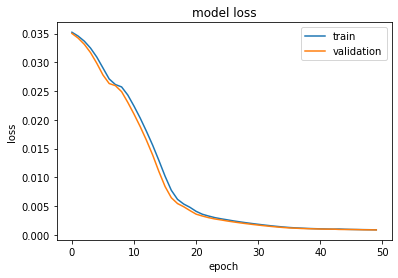

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [14]:
decoded_data = autoencoder.predict(np.array([test_set[10]]))

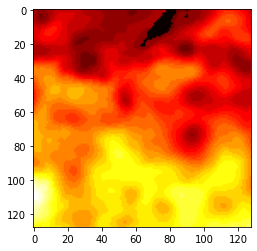

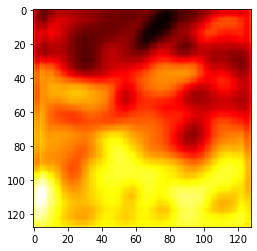

In [22]:
plt.imshow(test_set[10],cmap='hot')
plt.show()
plt.imshow(decoded_data[0,:,:,0],cmap='hot')
plt.show()

Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 128, 128, 2)       20        
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 64, 64, 1)         19        
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_transpose_174 (Conv2D (None, 32, 32, 1)         10        
_________________________________________________________________
conv2d_transpose_175 (Conv2D (None, 32, 32, 2)         20 

4/4 [==============================] - 1s 146ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 68/100
4/4 [==============================] - 1s 137ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 69/100
4/4 [==============================] - 1s 146ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 70/100
4/4 [==============================] - 1s 134ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 71/100
4/4 [==============================] - 1s 141ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 72/100
4/4 [==============================] - 1s 138ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 73/100
4/4 [==============================] - 1s 142ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 74/100
4/4 [==============================] - 1s 135ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 75/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 76/100
4/4 [==============================] - 1s 150ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 77/100


4/4 [==============================] - 1s 154ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 27/100
4/4 [==============================] - 1s 144ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 28/100
4/4 [==============================] - 1s 163ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 29/100
4/4 [==============================] - 1s 152ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 30/100
4/4 [==============================] - 1s 159ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 31/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 32/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 33/100
4/4 [==============================] - 1s 155ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 34/100
4/4 [==============================] - 1s 156ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 35/100
4/4 [==============================] - 1s 161ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 36/100


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_transpose_180 (Conv2D (None, 32, 32, 4)         148       
_________________________________________________________________
conv2d_transpose_181 (Conv2D (None, 32, 32, 8)         296

4/4 [==============================] - 1s 205ms/step - loss: 6.7106e-04 - val_loss: 6.5534e-04
Epoch 67/100
4/4 [==============================] - 1s 209ms/step - loss: 6.5817e-04 - val_loss: 6.4577e-04
Epoch 68/100
4/4 [==============================] - 1s 221ms/step - loss: 6.5003e-04 - val_loss: 6.3850e-04
Epoch 69/100
4/4 [==============================] - 1s 214ms/step - loss: 6.4313e-04 - val_loss: 6.4473e-04
Epoch 70/100
4/4 [==============================] - 1s 201ms/step - loss: 6.3934e-04 - val_loss: 6.3180e-04
Epoch 71/100
4/4 [==============================] - 1s 212ms/step - loss: 6.2734e-04 - val_loss: 6.0937e-04
Epoch 72/100
4/4 [==============================] - 1s 211ms/step - loss: 6.1029e-04 - val_loss: 5.9791e-04
Epoch 73/100
4/4 [==============================] - 1s 205ms/step - loss: 6.0165e-04 - val_loss: 5.8890e-04
Epoch 74/100
4/4 [==============================] - 1s 225ms/step - loss: 5.9205e-04 - val_loss: 5.8276e-04
Epoch 75/100
4/4 [=======================

4/4 [==============================] - 1s 227ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 23/100
4/4 [==============================] - 1s 222ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 24/100
4/4 [==============================] - 1s 214ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 25/100
4/4 [==============================] - 1s 221ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 26/100
4/4 [==============================] - 1s 220ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 27/100
4/4 [==============================] - 1s 218ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 28/100
4/4 [==============================] - 1s 221ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 29/100
4/4 [==============================] - 1s 218ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 30/100
4/4 [==============================] - 1s 216ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 31/100
4/4 [==============================] - 1s 219ms/step - loss: 0.0010 - val_loss: 9.4024e-04
Epoch 32/

4/4 [==============================] - 1s 220ms/step - loss: 4.3183e-04 - val_loss: 3.9386e-04
Epoch 99/100
4/4 [==============================] - 1s 218ms/step - loss: 4.1334e-04 - val_loss: 3.7970e-04
Epoch 100/100
4/4 [==============================] - 1s 218ms/step - loss: 3.8426e-04 - val_loss: 3.9190e-04


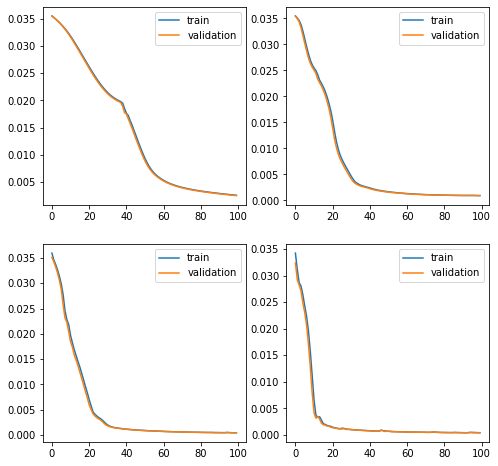

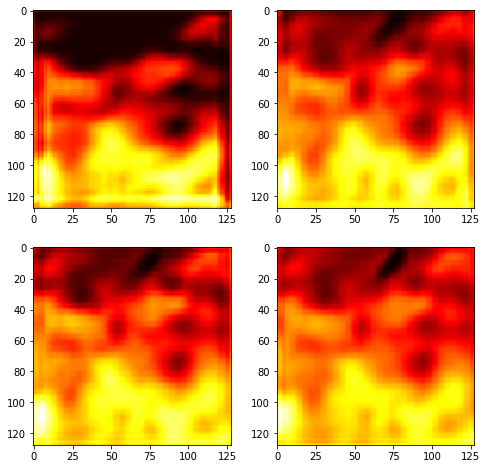

In [66]:
input_img = keras.Input(shape=(lat, long,1))

fig1 = plt.figure(figsize=(8,8)) # mse loss
fig2 = plt.figure(figsize=(8,8)) # image

for i in range(1,5):
    x = layers.Conv2D(math.pow(2,i), (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(math.pow(2,i-1), (3, 3), activation='relu',strides=(1,1), padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2DTranspose(math.pow(2,i-1), (3, 3), activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(math.pow(2,i), (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((4, 4))(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

    decoded_data = autoencoder.predict(np.array([test_set[10]]))
    
    ax1 = fig1.add_subplot(2,2,i)
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'validation'], loc='upper right')
    
    ax2 = fig2.add_subplot(2,2,i)
    ax2.imshow(decoded_data[0,:,:,0],cmap='hot')

Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 32, 32, 4)         0         
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 16, 16, 4)         0         
_________________________________________________________________
conv2d_transpose_215 (Conv2D (None, 16, 16, 4)         148

4/4 [==============================] - 1s 169ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 64/100
4/4 [==============================] - 1s 172ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 65/100
4/4 [==============================] - 1s 163ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 66/100
4/4 [==============================] - 1s 163ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 67/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 68/100
4/4 [==============================] - 1s 164ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 69/100
4/4 [==============================] - 1s 162ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 70/100
4/4 [==============================] - 1s 162ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 71/100
4/4 [==============================] - 1s 170ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 72/100
4/4 [==============================] - 1s 166ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 73/100


Epoch 17/100
4/4 [==============================] - 1s 164ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 18/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 19/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 20/100
4/4 [==============================] - 1s 170ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 21/100
4/4 [==============================] - 1s 164ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 22/100
4/4 [==============================] - 1s 166ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 23/100
4/4 [==============================] - 1s 176ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 24/100
4/4 [==============================] - 1s 165ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 25/100
4/4 [==============================] - 1s 179ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 26/100
4/4 [==============================] - 1s 166ms/step - loss: 0.0040 - val_loss: 0.0038


Epoch 99/100
4/4 [==============================] - 1s 170ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 100/100
4/4 [==============================] - 1s 177ms/step - loss: 0.0012 - val_loss: 0.0012
Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 32, 32, 4)         0         
_______________________________________________________

4/4 [==============================] - 1s 179ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 55/100
4/4 [==============================] - 1s 170ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 56/100
4/4 [==============================] - 1s 177ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 57/100
4/4 [==============================] - 1s 184ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 58/100
4/4 [==============================] - 1s 184ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 59/100
4/4 [==============================] - 1s 172ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 60/100
4/4 [==============================] - 1s 176ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 61/100
4/4 [==============================] - 1s 182ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 62/100
4/4 [==============================] - 1s 176ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 63/100
4/4 [==============================] - 1s 171ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 64/100


4/4 [==============================] - 1s 168ms/step - loss: 0.0211 - val_loss: 0.0193
Epoch 10/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0187 - val_loss: 0.0167
Epoch 11/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0161 - val_loss: 0.0140
Epoch 12/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0136 - val_loss: 0.0116
Epoch 13/100
4/4 [==============================] - 1s 175ms/step - loss: 0.0112 - val_loss: 0.0093
Epoch 14/100
4/4 [==============================] - 1s 165ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 15/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 16/100
4/4 [==============================] - 1s 171ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 17/100
4/4 [==============================] - 1s 171ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 18/100
4/4 [==============================] - 1s 170ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 19/100


4/4 [==============================] - 1s 178ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 92/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 93/100
4/4 [==============================] - 1s 164ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 94/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 95/100
4/4 [==============================] - 1s 166ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 96/100
4/4 [==============================] - 1s 164ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 97/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 98/100
4/4 [==============================] - 1s 170ms/step - loss: 0.0010 - val_loss: 9.9603e-04
Epoch 99/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0010 - val_loss: 9.9148e-04
Epoch 100/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0010 - val_loss: 9.8642e-04


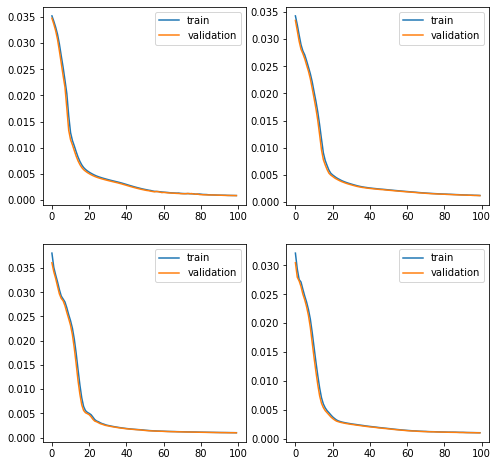

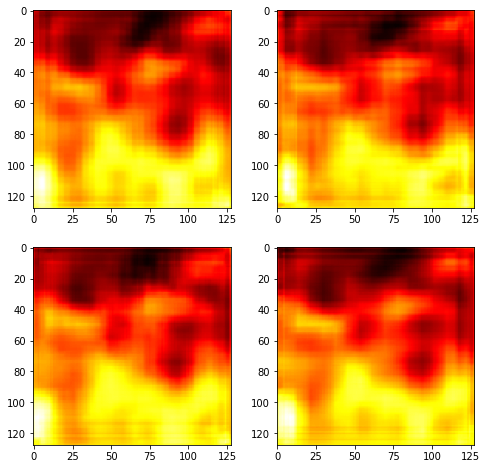

In [74]:
fig3 = plt.figure(figsize=(8,8)) # mse loss
fig4 = plt.figure(figsize=(8,8)) # image

for i in range(1,5):
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(4, (3, 3), activation='relu',strides=(1,1), padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

    decoded_data = autoencoder.predict(np.array([test_set[10]]))
    
    ax1 = fig3.add_subplot(2,2,i)
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'validation'], loc='upper right')
    
    ax2 = fig4.add_subplot(2,2,i)
    ax2.imshow(decoded_data[0,:,:,0],cmap='hot')

TypeError: 'Text' object is not callable

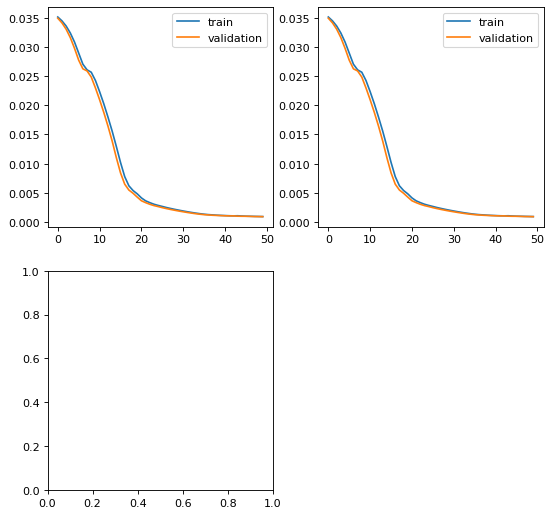

In [49]:
plt.figure(figsize=(8,8), dpi=80)
plt.figure(1)
ind = "222"
ax1= plt.subplot(int(ind))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'validation'], loc='upper right')

ind = "221"
ax1= plt.subplot(int(ind))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'validation'], loc='upper right')

ind = "223"
ax1= plt.subplot(int(ind))
ax1.title("a")
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'validation'], loc='upper right')

ind = "224"
ax1= plt.subplot(int(ind))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'validation'], loc='upper right')